# Sistem Rekomendasi Buku

Import library

In [1]:
import pandas as pd
import numpy as np 
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Unzip folder dataset

In [2]:
!unzip /content/Book.zip

Archive:  /content/Book.zip
replace book_tags.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: book_tags.csv           
  inflating: books.csv               
  inflating: ratings.csv             
  inflating: sample_book.xml         
  inflating: tags.csv                
  inflating: to_read.csv             


Load data

In [61]:
books = pd.read_csv('/content/books.csv')
ratings = pd.read_csv('/content/ratings.csv')
book_tags = pd.read_csv('/content/book_tags.csv')
tags = pd.read_csv('/content/tags.csv')
 
print('Jumlah data buku: ', len(books.book_id.unique()))
print('Jumlah data rating: ', len(ratings))
print('Jumlah data tags buku: ', len(book_tags.tag_id.unique()))
print('Jumlah data jenis tags: ', len(book_tags.tag_id.unique()))

Jumlah data buku:  10000
Jumlah data rating:  981756
Jumlah data tags buku:  34252
Jumlah data jenis tags:  34252


## Exploratory Data Analysis

Pada proses ini akan dilakukan analisis pada setiap data yang akan dipakai.

### Books

Melihat informasi nama fitur, tipe data, jumlah null values, jumlah nilai unik, dan sampel dari nilai unik pada dataset book.csv

In [4]:
pd.DataFrame({'Features': books.columns,
              'dataType': books.dtypes.values,
              'nullvalues': [books[i].isna().sum() for i in books.columns],
              'unique': [books[i].nunique() for i in books.columns],
              'uniqueSample': [list(pd.Series(books[i].unique()))
                               for i in books.columns]}).reset_index(drop=True)

,Features,dataType,nullvalues,unique,uniqueSample
0,id,int64,0,10000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,book_id,int64,0,10000,"[2767052, 3, 41865, 2657, 4671, 11870085, 5907..."
2,best_book_id,int64,0,10000,"[2767052, 3, 41865, 2657, 4671, 11870085, 5907..."
3,work_id,int64,0,10000,"[2792775, 4640799, 3212258, 3275794, 245494, 1..."
4,books_count,int64,0,597,"[272, 491, 226, 487, 1356, 969, 360, 311, 3455..."
5,isbn,object,700,9300,"[439023483, 439554934, 316015849, 61120081, 74..."
6,isbn13,float64,585,9153,"[9780439023480.0, 9780439554930.0, 97803160158..."
7,authors,object,0,4664,"[Suzanne Collins, J.K. Rowling, Mary GrandPré,..."
8,original_publication_year,float64,21,293,"[2008.0, 1997.0, 2005.0, 1960.0, 1925.0, 2012...."
9,original_title,object,585,9274,"[The Hunger Games, Harry Potter and the Philos..."


Memilih kolom dapat dipakai untuk membuat sistem rekomendasi

In [5]:
books = books[['book_id', 'title']]

### Ratings

Melihat informasi nama fitur, tipe data, jumlah null values, jumlah nilai unik, dan sampel dari nilai unik pada dataset ratings.csv

In [6]:
pd.DataFrame({'Features': ratings.columns,
              'dataType': ratings.dtypes.values,
              'nullvalues': [ratings[i].isna().sum() for i in ratings.columns],
              'unique': [ratings[i].nunique() for i in ratings.columns],
              'uniqueSample': [list(pd.Series(ratings[i].unique()))
                               for i in ratings.columns]}).reset_index(drop=True)

,Features,dataType,nullvalues,unique,uniqueSample
0,book_id,int64,0,10000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,user_id,int64,0,53424,"[314, 439, 588, 1169, 1185, 2077, 2487, 2900, ..."
2,rating,int64,0,5,"[5, 3, 4, 1, 2]"


### Book Tags

Melihat informasi nama fitur, tipe data, jumlah null values, jumlah nilai unik, dan sampel dari nilai unik pada dataset book_tags.csv

In [7]:
pd.DataFrame({'Features': book_tags.columns,
              'dataType': book_tags.dtypes.values,
              'nullvalues': [book_tags[i].isna().sum() for i in book_tags.columns],
              'unique': [book_tags[i].nunique() for i in book_tags.columns],
              'uniqueSample': [list(pd.Series(book_tags[i].unique()))
                               for i in book_tags.columns]}).reset_index(drop=True)

,Features,dataType,nullvalues,unique,uniqueSample
0,goodreads_book_id,int64,0,10000,"[1, 2, 3, 5, 6, 8, 10, 11, 13, 21, 24, 25, 26,..."
1,tag_id,int64,0,34252,"[30574, 11305, 11557, 8717, 33114, 11743, 1401..."
2,count,int64,0,9401,"[167697, 37174, 34173, 12986, 12716, 9954, 716..."


Mengganti nama kolom goodreads_book_id

In [8]:
book_tags.rename(columns = {'goodreads_book_id':'book_id'}, inplace = True)

### Tags

Melihat informasi nama fitur, tipe data, jumlah null values, jumlah nilai unik, dan sampel dari nilai unik pada dataset tags.csv

In [9]:
pd.DataFrame({'Features': tags.columns,
              'dataType': tags.dtypes.values,
              'nullvalues': [tags[i].isna().sum() for i in tags.columns],
              'unique': [tags[i].nunique() for i in tags.columns],
              'uniqueSample': [list(pd.Series(tags[i].unique()))
                               for i in tags.columns]}).reset_index(drop=True)

,Features,dataType,nullvalues,unique,uniqueSample
0,tag_id,int64,0,34252,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,tag_name,object,0,34252,"[-, --1-, --10-, --12-, --122-, --166-, --17-,..."


## Preprocessing

Menggabungkan seluruh book_id pada kategori buku ke dalam satu dataframe

In [10]:
tags_all = (pd.merge(book_tags, tags, on='tag_id'))
book_all = (pd.merge(tags_all, books, on='book_id'))
book_all = book_all.drop(columns=["tag_id", "count"])
book_all.head()

,book_id,tag_name,title
0,1,to-read,Harry Potter and the Half-Blood Prince (Harry ...
1,1,fantasy,Harry Potter and the Half-Blood Prince (Harry ...
2,1,favorites,Harry Potter and the Half-Blood Prince (Harry ...
3,1,currently-reading,Harry Potter and the Half-Blood Prince (Harry ...
4,1,young-adult,Harry Potter and the Half-Blood Prince (Harry ...


Menggabungkan tag name sesuai dengan book_id dan title

In [11]:
data = book_all.groupby(['book_id', 'title']).tag_name.apply(lambda x : ','.join(set(x))).reset_index()
data.head()

,book_id,title,tag_name
0,1,Harry Potter and the Half-Blood Prince (Harry ...,"read-in-2014,favourite-books,own-it,children-s..."
1,2,Harry Potter and the Order of the Phoenix (Har...,"read-in-2014,own-it,children-s-literature,harr..."
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,"read-in-2014,favourite-books,own-it,children-s..."
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,"read-in-2014,favourite-books,own-it,children-s..."
4,6,Harry Potter and the Goblet of Fire (Harry Pot...,"read-in-2014,favourite-books,own-it,children-s..."


Mengecek jumlah buku

In [12]:
len(data.book_id.unique())

10000

## Content Based Filtering

Mengambil fitur tag name dengan TfidfVectorizer()

In [13]:
tf = TfidfVectorizer()
tf.fit(data['tag_name']) 
tf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['00',
 '000',
 '0000',
 '00000',
 '0000_notverified',
 '000src',
 '001',
 '002',
 '005',
 '007',
 '008',
 '01',
 '016',
 '01_best',
 '02',
 '0201',
 '021614',
 '0227528',
 '029',
 '03',
 '0300',
 '0303',
 '04',
 '0471239720',
 '05',
 '05ip9hg',
 '06',
 '07',
 '07july',
 '08',
 '09',
 '0cant',
 '0fiction',
 '0nonfiction',
 '0want',
 '0wn',
 '0wned',
 '10',
 '100',
 '1000',
 '10000',
 '1000s',
 '1001',
 '1001books',
 '1009',
 '100s',
 '101',
 '101st',
 '102',
 '103',
 '10k',
 '10th',
 '11',
 '110',
 '1100s',
 '111',
 '1111',
 '11th',
 '12',
 '12017',
 '122',
 '123',
 '12s',
 '12th',
 '13',
 '1300',
 '1300s',
 '1350',
 '1395',
 '13th',
 '14',
 '1400s',
 '140924',
 '1421',
 '1438',
 '1452',
 '14th',
 '14艺术美学',
 '15',
 '150',
 '1500',
 '1500s',
 '150321',
 '1507',
 '150913',
 '1519',
 '1537',
 '1543',
 '1553',
 '1564',
 '158',
 '15th',
 '16',
 '1600',
 '1600s',
 '160409',
 '1616',
 '1643',
 '166',
 '1660s',
 '1665',
 '16th',
 '17',
 '1700',
 '1700s',
 '1702',
 '1714',
 '1715',
 '1737',
 '1

Melakukan fit lalu ditransformasikan ke bentuk matrix dan melihat ukuran matrix

In [14]:
tfidf_matrix = tf.fit_transform(data['tag_name']) 
tfidf_matrix.shape

(10000, 16611)

Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()

In [15]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Membuat dataframe untuk melihat tf-idf matrix

In [16]:
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names(),
    index=data.title
).sample(22, axis=1).sample(10, axis=0)

,سخيفة,berkshire,métafiction,wide,counselors,portraits,taita,popularity,das,hillenbrand,...,offenses,horror,yukon,diving,48,repeated,03,picks,spiegelman,shapeshifter
title,,,,,,,,,,,,,,,,,,,,,
"A Caribbean Mystery (Miss Marple, #10)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Trouble,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Tempest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Blaze,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.074028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Tiger's Wife,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"The Restaurant at the End of the Universe (Hitchhiker's Guide, #2)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Gospel According to Jesus Christ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Right Ho, Jeeves (Jeeves, #6)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Sweet Tooth, Volume 1: Out of the Deep Woods",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.027720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Menghitung cosine similarity pada matrix tf-idf

In [17]:
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1.        , 0.85917123, 0.95757127, ..., 0.19274084, 0.12356331,
        0.16168041],
       [0.85917123, 1.        , 0.84001366, ..., 0.17727705, 0.10292726,
        0.1279642 ],
       [0.95757127, 0.84001366, 1.        , ..., 0.18552877, 0.11849384,
        0.14655845],
       ...,
       [0.19274084, 0.17727705, 0.18552877, ..., 1.        , 0.32710369,
        0.23490192],
       [0.12356331, 0.10292726, 0.11849384, ..., 0.32710369, 1.        ,
        0.39329412],
       [0.16168041, 0.1279642 , 0.14655845, ..., 0.23490192, 0.39329412,
        1.        ]])

Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama buku

Melihat similarity matrix pada setiap buku

In [18]:

cosine_sim_df = pd.DataFrame(cosine_sim, index=data['title'], columns=data['title'])
print('Shape:', cosine_sim_df.shape)
 

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (10000, 10000)


title,The Demolished Man,"The Girl In The Ice (Detective Erika Foster, #1)","Shopaholic & Baby (Shopaholic, #5)","The Elfstones of Shannara (The Original Shannara Trilogy, #2)",The Summer Tree (The Fionavar Tapestry #1)
title,,,,,
Americanah,0.085051,0.209467,0.229410,0.128746,0.146350
The Power of a Praying Wife,0.032303,0.082738,0.099465,0.064397,0.059839
Hunger Makes Me a Modern Girl,0.055759,0.174992,0.147070,0.089713,0.091710
Mister B. Gone,0.172997,0.212813,0.255948,0.360694,0.325832
"Dearly Devoted Dexter (Dexter, #2)",0.081821,0.589641,0.225551,0.118617,0.110014
Captains and the Kings,0.071405,0.115857,0.166795,0.120078,0.133975
The Good Guy,0.089460,0.482013,0.173401,0.124271,0.112124
Tempting Fate,0.095391,0.285410,0.425457,0.177139,0.183493
"Broken Angels (Takeshi Kovacs, #2)",0.268786,0.096004,0.080284,0.355164,0.351004


Membuat fungsi untuk menunjukan hasil rekomendasi

In [19]:
def book_recommendations(title, similarity_data=cosine_sim_df, items=data[['title', 'tag_name']], k=5):
    index = similarity_data.loc[:,title].to_numpy().argpartition(
        range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(title, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

### Testing 1

In [20]:
data[data.title.eq('Flowers in the Attic (Dollanganger, #1)')]

,book_id,title,tag_name
2397,43448,"Flowers in the Attic (Dollanganger, #1)","read-in-2014,family,dnf,library,currently-read..."


In [21]:
book_recommendations('Flowers in the Attic (Dollanganger, #1)')

,title,tag_name
0,"Petals on the Wind (Dollanganger, #2)","read-in-2014,family,dnf,library,my-bookshelf,f..."
1,"If There Be Thorns (Dollanganger, #3)","vcandrews,read-in-2014,family,library,my-books..."
2,"Seeds of Yesterday (Dollanganger, #4)","vcandrews,read-in-2014,family,own-it,library,m..."
3,"Garden of Shadows (Dollanganger, #5)","vcandrews,read-in-2014,read-as-a-kid,family,se..."
4,"My Sweet Audrina (Audrina, #1)","vcandrews,family,dnf,stand-alones,own-it,libra..."


### Testing 2

In [22]:
data[data.title.eq('Soulless (Parasol Protectorate, #1)')]

,book_id,title,tag_name
6690,6381205,"Soulless (Parasol Protectorate, #1)","read-in-2014,dnf,funny,sff,london,library,para..."


In [23]:
book_recommendations('Soulless (Parasol Protectorate, #1)')

,title,tag_name
0,"Changeless (Parasol Protectorate, #2)","read-in-2014,scotland,funny,sff,paranormal-fan..."
1,"Blameless (Parasol Protectorate, #3)","read-in-2014,funny,sff,london,library,paranorm..."
2,"Timeless (Parasol Protectorate, #5)","read-in-2014,own-it,funny,sff,london,library,p..."
3,"Curtsies & Conspiracies (Finishing School, #2)","read-in-2014,spy,funny,library,audio-books,fem..."
4,"Heartless (Parasol Protectorate, #4)","read-in-2014,2011-reads,own-it,funny,sff,londo..."


### Testing 3

In [24]:
data[data.title.eq('I Capture the Castle')]

,book_id,title,tag_name
1946,31122,I Capture the Castle,"read-in-2014,favourite-books,family,literary,o..."


In [25]:
book_recommendations('I Capture the Castle')

,title,tag_name
0,When God Was a Rabbit,"read-in-2014,favourite-books,family,2011-reads..."
1,Persuasion,"read-in-2014,literary,own-it,library,audio-boo..."
2,Black Swan Green,"age,read-in-2014,family,dnf,literary,own-it,fu..."
3,Cold Comfort Farm,"read-in-2014,family,dnf,women-writers,own-it,f..."
4,Lorna Doone,"digital,favourite-books,classics-challenge,dnf..."


## Collaborative Filtering

In [27]:
df = ratings
df

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4
...,...,...,...
981751,10000,48386,5
981752,10000,49007,4
981753,10000,49383,5
981754,10000,50124,5


Melakukan encoding pada kolom user_id

In [28]:
user_ids = df['user_id'].unique().tolist()
print('list user_id: ', user_ids)
 
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded user_id : ', user_to_user_encoded)
 
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke user_id: ', user_encoded_to_user)

list user_id:  [314, 439, 588, 1169, 1185, 2077, 2487, 2900, 3662, 3922, 5379, 5461, 5885, 6630, 7563, 9246, 10140, 10146, 10246, 10335, 10610, 10944, 11854, 11927, 12471, 13282, 13544, 15494, 16377, 16913, 17434, 17663, 17984, 18031, 18313, 18361, 20076, 20467, 20848, 21228, 21487, 21713, 22602, 23576, 23612, 24326, 24389, 24499, 24834, 24845, 25164, 25182, 25214, 26145, 26629, 26661, 28158, 28767, 29123, 29703, 30681, 31001, 32055, 32305, 32592, 32635, 32748, 32923, 33065, 33697, 33716, 33872, 33890, 37284, 37834, 38080, 38082, 38475, 39423, 41074, 42404, 43985, 44243, 44397, 45269, 45493, 46977, 47476, 47746, 47800, 48482, 49298, 50104, 50342, 51166, 51460, 51480, 51838, 52036, 53245, 3022, 5115, 5436, 6063, 6342, 8167, 9731, 10111, 10288, 10509, 10751, 11285, 11408, 11691, 11692, 11868, 11945, 12874, 12946, 13794, 14372, 14546, 14603, 15604, 17566, 17643, 19526, 19724, 19729, 19942, 21217, 21676, 21733, 27499, 30313, 30944, 32918, 36099, 42508, 42810, 46421, 47478, 48559, 48687, 50

Melakukan encoding pada kolom book_id

In [29]:
book_ids = df['book_id'].unique().tolist()
book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}
book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}

Mapping user_id dan book_id ke dataframe user dan book

In [30]:
df['user'] = df['user_id'].map(user_to_user_encoded)
df['book'] = df['book_id'].map(book_to_book_encoded)

Mencari jumlah user dan book

In [31]:
num_users = len(user_to_user_encoded)
print(num_users)
 
num_book = len(book_encoded_to_book)
print(num_book)
 
df['rating'] = df['rating'].values.astype(np.float32)

min_rating = min(df['rating'])
 
max_rating = max(df['rating'])
 
print('Number of User: {}, Number of book: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_book, min_rating, max_rating
))

53424
10000
Number of User: 53424, Number of book: 10000, Min Rating: 1.0, Max Rating: 5.0


Mengacak dataset

In [32]:
df = df.sample(frac=1, random_state=42)
df

,book_id,user_id,rating,user,book
646451,6495,19643,5.0,6235,6494
614851,6175,8563,4.0,22868,6174
974393,9920,52110,3.0,20830,9919
21471,215,33864,5.0,326,214
272540,2728,16587,3.0,296,2727
...,...,...,...,...,...
259178,2594,26266,4.0,1106,2593
365838,3663,27212,5.0,11405,3662
131932,1320,31839,4.0,5430,1319
671155,6746,34952,2.0,2490,6745


Mencocokkan data user dan book

In [33]:
x = df[['user', 'book']].values
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

Membagi menjadi 80% data train dan 20% data validasi

In [34]:
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

[[ 6235  6494]
 [22868  6174]
 [20830  9919]
 ...
 [ 5430  1319]
 [ 2490  6745]
 [   67  1219]] [1.   0.75 0.5  ... 0.75 0.25 0.5 ]


Membuat class untuk sistem rekomendasi

In [38]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_resto, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_resto = num_resto
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.resto_embedding = layers.Embedding( # layer embeddings resto
        num_resto,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.resto_bias = layers.Embedding(num_resto, 1) # layer embedding resto bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    resto_vector = self.resto_embedding(inputs[:, 1]) # memanggil layer embedding 3
    resto_bias = self.resto_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_resto = tf.tensordot(user_vector, resto_vector, 2) 
 
    x = dot_user_resto + user_bias + resto_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

Inisialisasi model

In [39]:
model = RecommenderNet(num_users, num_book, 50)
 
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Memulai training
 


In [41]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    steps_per_epoch=1000,
    epochs = 20,
    validation_data = (x_val, y_val)
)

Epoch 1/20
1000/1000 [==============================] - 45s 45ms/step - loss: 0.6763 - root_mean_squared_error: 0.3089 - val_loss: 0.6757 - val_root_mean_squared_error: 0.3115
Epoch 2/20
1000/1000 [==============================] - 45s 45ms/step - loss: 0.6727 - root_mean_squared_error: 0.3108 - val_loss: 0.6721 - val_root_mean_squared_error: 0.3083
Epoch 3/20
1000/1000 [==============================] - 45s 45ms/step - loss: 0.6692 - root_mean_squared_error: 0.3043 - val_loss: 0.6684 - val_root_mean_squared_error: 0.3051
Epoch 4/20
1000/1000 [==============================] - 46s 46ms/step - loss: 0.6643 - root_mean_squared_error: 0.3043 - val_loss: 0.6645 - val_root_mean_squared_error: 0.3017
Epoch 5/20
1000/1000 [==============================] - 87s 87ms/step - loss: 0.6617 - root_mean_squared_error: 0.2984 - val_loss: 0.6606 - val_root_mean_squared_error: 0.2982
Epoch 6/20
1000/1000 [==============================] - 46s 46ms/step - loss: 0.6569 - root_mean_squared_error: 0.2939 -

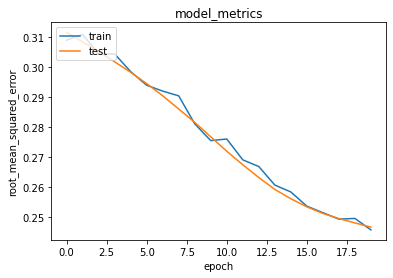

In [42]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [58]:
book_df = data
df = pd.read_csv('ratings.csv')
 
user_id = df.user_id.sample(1).iloc[0]
book_read_by_user = df[df.user_id == user_id]
 
book_not_read = book_df[~book_df['book_id'].isin(book_read_by_user.book_id.values)]['book_id'] 
book_not_read = list(
    set(book_not_read)
    .intersection(set(book_to_book_encoded.keys()))
)
 
book_not_read = [[book_to_book_encoded.get(x)] for x in book_not_read]
user_encoder = user_to_user_encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_not_read), book_not_read)
)

In [59]:
ratings = model.predict(user_book_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_book_ids = [
    book_encoded_to_book.get(book_not_read[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('book with high ratings from user')
print('----' * 8)
 
top_book_user = (
    book_read_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .book_id.values
)
 
book_df_rows = book_df[book_df['book_id'].isin(top_book_user)]
for row in book_df_rows.itertuples():
    print(row.book_name, ':', row.cuisine)
 
print('----' * 8)
print('Top 10 book recommendation')
print('----' * 8)

recommended_book = book_df[book_df['book_id'].isin(recommended_book_ids)]
for row in recommended_book.itertuples():
    print(row.title, ':', row.tag_name)

25/25 [==============================] - 0s 4ms/step
Showing recommendations for users: 25214
book with high ratings from user
--------------------------------
--------------------------------
Top 10 book recommendation
--------------------------------
Harry Potter and the Order of the Phoenix (Harry Potter, #5) : read-in-2014,own-it,children-s-literature,harry-potter-series,library,audio-books,children-s-lit,female-author,kids-books,currently-reading,audiobook,finished,mystery,hp,fantasia,fantasy-scifi,british,re-reads,sci-fi,paranormal,magic,juvenile,fiction,fantasy-fiction,urban-fantasy,read-multiple-times,audio,scifi-fantasy,my-library,to-read,kids,read-again,childrens-lit,ya-books,default,juvenile-fiction,read-in-2011,middle-school,science-fiction-fantasy,youth,my-favorites,ya,movie,boarding-school,favorite,ya-fantasy,favourite,rowling,favorites,read-in-2017,favs,favourites,potter,novel,books-i-have,ya-fiction,teen,magical,5-star,audiobooks,young-adult-fantasy,harry-potter,owned,c